#Speech Articulatory Coding (SPARC)

This lab provides hands-on experience in using Speech Articulatory Coding (SPARC) model.

SPARC is a neural encoding-decoding framework that encodes speech into 14 articulatory features (50Hz) with a disentangled speaker embedding. The individual channel in articulatory features corresponds to a physical articulator on the vocal tract, making the features interpretable, controllable and grounded. The decoder synthesizes those features back to speech audio. Please check the [paper](https://arxiv.org/abs/2406.12998) for detail.

In [2]:
# Installation

!git clone https://github.com/Berkeley-Speech-Group/Speech-Articulatory-Coding.git

Cloning into 'Speech-Articulatory-Coding'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 139 (delta 57), reused 105 (delta 28), pack-reused 0 (from 0)
Receiving objects: 100% (139/139), 20.02 MiB | 16.23 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [3]:
!pip install -e /content/Speech-Articulatory-Coding/.

Obtaining file:///content/Speech-Articulatory-Coding
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import sys
sys.path.append("/content/Speech-Articulatory-Coding/")

In [5]:
# audio samples
!ls /content/Speech-Articulatory-Coding/sample_audio

chinese.wav  french.wav  italian.wav  sample1.wav  sample2.wav	spanish.wav


In [6]:
from sparc import load_model
import soundfile as sf
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

color_code = {"UL":matplotlib.colors.to_rgb("#EE3A5B"),
              "LL":matplotlib.colors.to_rgb("#FFD155"),
              "LI":matplotlib.colors.to_rgb("#959595"),
              "TT":matplotlib.colors.to_rgb("#43B962"),
              "TB":matplotlib.colors.to_rgb("#C44B9F"),
              "TD":matplotlib.colors.to_rgb("#0093B7"),
              "Loudness":matplotlib.colors.to_rgb("#FB754D"),
              "Pitch":matplotlib.colors.to_rgb("#FB754D"),}

def plot_art(ax, art, gap=5, skip_y=False,color=None,alpha=1.0, lw=2):
    yticks=[]
    ytick_labels=[]
    labels = ["UL","LL", "LI", "TT", "TB", "TD"]
    chidxs = []
    EMA_channel_label = ['TDX','TDY','TBX','TBY','TTX','TTY','LIX','LIY','ULX','ULY','LLX','LLY']
    channel_label = EMA_channel_label
    for l in labels:
        chidxs.append(EMA_channel_label.index(l+"X"))
        chidxs.append(EMA_channel_label.index(l+"Y"))


    for i,ch_i in enumerate(chidxs):
        ch_label = channel_label[ch_i]
        ytick_labels.append(ch_label)
        if ch_i < 12:
            art_name= ch_label[:2]
            if color is None:
                color = color_code[art_name]
            ax.plot(art[:,ch_i]-gap*i,color=color,alpha=alpha,lw=lw)
        else:
            art_name= ch_label
            if color is None:
                color = color_code[art_name]
            ax.plot(art[:,ch_i]-gap*i,color=color,alpha=alpha,lw=lw)
        yticks.append(-gap*i)
    if skip_y:
        ytick_labels = [""]*len(ytick_labels)

    ax.set_yticks(yticks,ytick_labels,fontsize=15)

    xticks= np.arange(0,len(art),50)
    xtick_labels= [f"{int(x*20/1000)}" for x in xticks]
    ax.set_xticks(xticks, xtick_labels,fontsize=15)
    ax.set_xlabel("Time (s)", fontsize=15)
    ax.set_xlim(0,len(art))
    return yticks

In [7]:
coder = load_model("en", device= "cuda", use_penn=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_english_1500k.yaml:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

model_english_1500k.ckpt:   0%|          | 0.00/66.2M [00:00<?, ?B/s]

/content/Speech-Articulatory-Coding/sparc/sparc.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt)


config.json:   0%|          | 0.00/2.22k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Using PENN for pitch tracking.


/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [8]:
from google.colab import drive
drive.mount('/content/drive')

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Resynthesis

In [ ]:
wav_file = '/content/Speech-Articulatory-Coding/sample_audio/diva_babbling-84.wav'

In [ ]:
# EMA channel_label = ['TDX','TDY','TBX','TBY','TTX','TTY','LIX','LIY','ULX','ULY','LLX','LLY']
code = coder.encode(wav_file)

In [ ]:
#shapes
for name, values in code.items():
  print(f"{name}: {values.shape}")

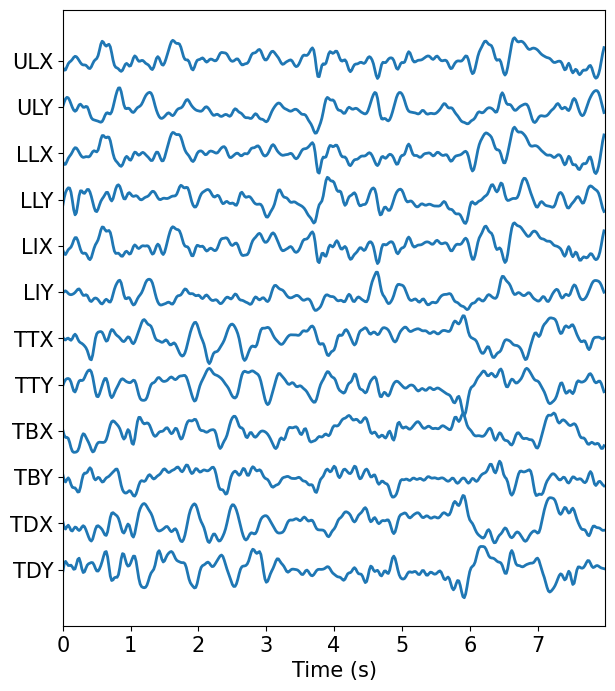

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(7,8))
plot_art(ax, code['ema'][:400], color='C0', gap=6, alpha=1, lw=2)
plt.show()

In [ ]:
wav = coder.decode(**code)

In [ ]:
# resynthesized
ipd.display(ipd.Audio(wav, rate=coder.sr))


In [ ]:
# ground truth reference
wavt,tsr = sf.read(wav_file)
ipd.display(ipd.Audio(wavt, rate=tsr))

## Zero-shot Voice Conversion

In [ ]:
src_wav_file = "/content/Speech-Articulatory-Coding/sample_audio/sample1.wav"
trg_wav_file = "/content/Speech-Articulatory-Coding/sample_audio/sample2.wav"

In [ ]:
# source audio
src_wav,sr = sf.read(src_wav_file)
ipd.display(ipd.Audio(src_wav, rate=sr))

# target audio
trg_wav,sr = sf.read(trg_wav_file)
ipd.display(ipd.Audio(trg_wav, rate=sr))

In [ ]:
converted_wav = coder.convert(src_wav_file, trg_wav_file)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [ ]:
# converted
ipd.display(ipd.Audio(converted_wav, rate=coder.sr))

In [ ]:
src_code = coder.encode(src_wav_file)
converted_code = coder.encode(converted_wav)

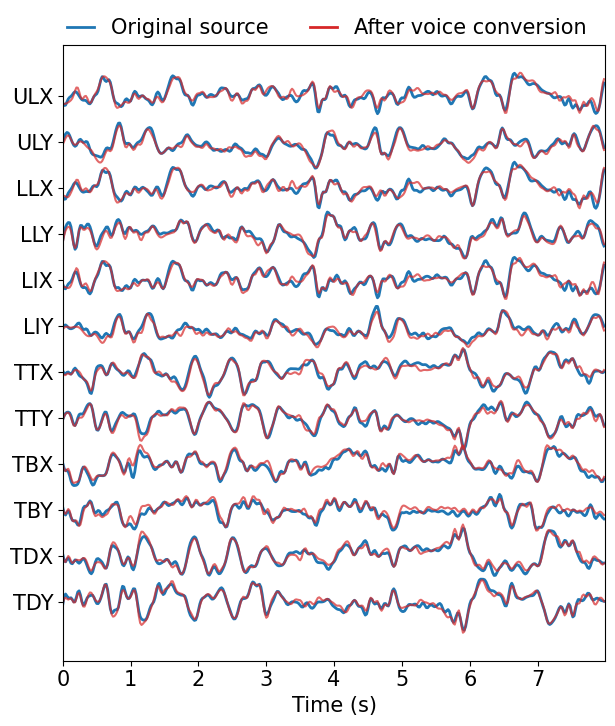

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(7,8))
plot_art(ax, src_code['ema'][:400], color='C0', gap=6, alpha=1, lw=2)
plot_art(ax, converted_code['ema'][:400], color='C3', gap= 6, alpha=0.7, lw=1.5)
ax.plot([],[],label="Original source", color='C0', lw=2)
ax.plot([],[],label="After voice conversion", color='C3', lw=2,)
ax.legend(fontsize=15, handlelength=1.3,loc='lower right',bbox_to_anchor=(1.0,0.98), ncol=2, frameon=False)
plt.show()

## Record Yourself!

In [ ]:
# Helper function for recording from Colab. Adapted from https://colab.research.google.com/drive/14v6co8Ec1JUAVdvuX4D08zxbRM1LmtxQ#scrollTo=9y4bzwMsh05H.
# You will need to grant mic permission.
from base64 import b64decode

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=5, file_name='recorded_audio.wav'):
  try:
    from google.colab import output
  except ImportError:
    print('No possible to import output from google.colab')
    return ''
  else:
    print('Recording')
    display(ipd.Javascript(RECORD))
    s = output.eval_js('record(%d)' % (sec*1000))
    print('Saving to', file_name)
    b = b64decode(s.split(',')[1])
    with open(file_name, 'wb') as f:
      f.write(b)
    return file_name

In [ ]:
# Recording from your laptop for 5 seconds. The file will be saved as 'recorded_audio.wav'.
# The file can be found in the navigator at the left panel, under the "content" folder.
# Download the files if you need, otherwise they will be deleted when the session ends.

record(sec=10, file_name='recorded_audio.wav')
!ffmpeg -y -i ./recorded_audio.wav recorded_audio.wav

Recording


<IPython.core.display.Javascript object>

Saving to recorded_audio.wav
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-lib

In [ ]:
code = coder.encode('recorded_audio.wav')

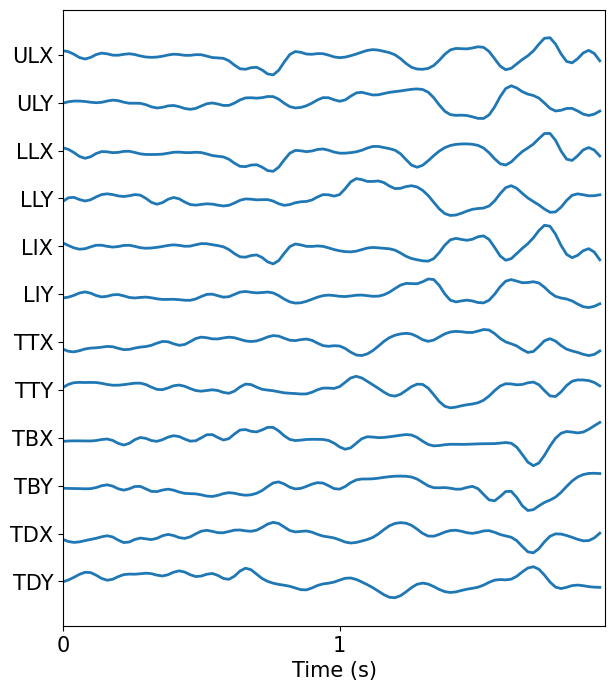

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(7,8))
plot_art(ax, code['ema'][:400], color='C0', gap=6, alpha=1, lw=2)
plt.show()

In [ ]:
wav = coder.decode(**code)

In [ ]:
# resynthesized
ipd.display(ipd.Audio(wav, rate=coder.sr))


In [ ]:
# ground truth reference
wavt,tsr = sf.read('recorded_audio.wav')
ipd.display(ipd.Audio(wavt, rate=tsr))